In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow Version: 2.20.0
GPU Available:  False


In [2]:
class TextPreprocessor:
    
    STOP_WORDS = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
        "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he',
        'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
        'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',
        'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
        'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
        'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
        'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
        'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
        'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
        'too', 'very'
    ])

    @staticmethod
    def clean(text):
       
        if not isinstance(text, str):
            return ""

        text = text.lower().strip()

        text = re.sub(r'[^\w\s]', '', text)
        
        tokens = text.split()

        filtered_tokens = [t for t in tokens if t not in TextPreprocessor.STOP_WORDS]

        return " ".join(filtered_tokens)

In [3]:
class LyricsClassifier:
    
    def __init__(self, max_vocab=20000, embed_dim=64, seq_len=100):
        self.max_vocab = max_vocab
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        self.model = None
        self.vectorizer = None

    def build_vectorizer(self, train_text):
        print("Adapting TextVectorizer to training data...")
        self.vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=self.max_vocab,
            output_mode='int',
            output_sequence_length=self.seq_len
        )
        self.vectorizer.adapt(train_text)

    def build_model(self, num_classes):
        print(f"Building model for {num_classes} classes...")
        
        inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
        
        x = self.vectorizer(inputs)
        
        x = tf.keras.layers.Embedding(
            input_dim=self.max_vocab, 
            output_dim=self.embed_dim, 
            mask_zero=True
        )(x)
        
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy']
        )
        self.model.summary()

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        return history

In [19]:

DATA_FILE = r"C:\Users\UserK\Desktop\ML\dataset\Spotify Million Song Dataset_exported.csv"
SAMPLE_LIMIT = 2000 

def generate_snippets(text, window_size=30, stride=15):

    if not isinstance(text, str): return []
    words = text.split()
    if len(words) < window_size:
        return [text] 
    
    snippets = []
    for i in range(0, len(words) - window_size, stride):
        snippet = " ".join(words[i : i + window_size])
        snippets.append(snippet)
    return snippets

print("Loading dataset...")
if not os.path.exists(DATA_FILE):
    print("Error: File not found.")
else:
    df = pd.read_csv(DATA_FILE)
    df['target_label'] = df['song'] + " - " + df['artist']
    df = df.dropna(subset=['text'])

    if SAMPLE_LIMIT:
        print(f"Selecting top {SAMPLE_LIMIT} songs...")
        df = df.head(SAMPLE_LIMIT)
    
    print("Cleaning lyrics...")
    df['clean_text'] = df['text'].apply(TextPreprocessor.clean)
    df = df[df['clean_text'].str.strip().astype(bool)]

    print("Generating snippets (chopping lyrics into pieces)...")
    
    all_snippets = []
    all_labels = []
    
    for _, row in df.iterrows():
        song_snippets = generate_snippets(row['clean_text'])
        all_snippets.extend(song_snippets)
        all_labels.extend([row['target_label']] * len(song_snippets))
        
    print(f"Created {len(all_snippets)} training samples from {len(df)} songs.")

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(all_labels)
    X = np.array(all_snippets) 
    
   
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Final Data: {len(X_train)} Train, {len(X_val)} Validation.")
    print(f"Number of Classes: {len(label_encoder.classes_)}")

Loading dataset...
Selecting top 2000 songs...
Cleaning lyrics...
Generating snippets (chopping lyrics into pieces)...
Created 12442 training samples from 2000 songs.
Final Data: 9953 Train, 2489 Validation.
Number of Classes: 2000


In [21]:
print("Converting training data to TensorFlow format...")
X_train_tf = tf.constant(X_train.tolist())
X_val_tf = tf.constant(X_val.tolist())
y_train_tf = tf.constant(y_train)
y_val_tf = tf.constant(y_val)

classifier = LyricsClassifier(max_vocab=30000, embed_dim=128, seq_len=120)

print("Adapting vectorizer...")
classifier.build_vectorizer(X_train_tf)

num_classes = len(label_encoder.classes_)
classifier.build_model(num_classes)

print("Starting training...")
history = classifier.train(X_train_tf, y_train_tf, X_val_tf, y_val_tf, epochs=15, batch_size=64)

Converting training data to TensorFlow format...
Adapting vectorizer...
Adapting TextVectorizer to training data...
Building model for 2000 classes...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 120)       │          0 │ input_layer_4[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 120, 128)  │  3,840,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 120)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ embedding_4[0][0… │
│ (GlobalAveragePool… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 2000)      │    258,000 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,114,512 (15.70 MB)

 Trainable params: 4,114,512 (15.70 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.0091 - loss: 7.5495 - val_accuracy: 0.0108 - val_loss: 7.3934
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.0159 - loss: 7.0186 - val_accuracy: 0.0398 - val_loss: 6.9863
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.0636 - loss: 6.3384 - val_accuracy: 0.0908 - val_loss: 6.4855
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.1739 - loss: 5.4030 - val_accuracy: 0.1908 - val_loss: 5.8273
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.3274 - loss: 4.2848 - val_accuracy: 0.3206 - val_loss: 5.0657
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.4903 - loss: 3.1892 - val_accuracy: 0.4243 - val_loss: 4.3748
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.6198 - loss: 2.3235 - val_accuracy: 0.4990 - val_loss: 3.8218
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.7

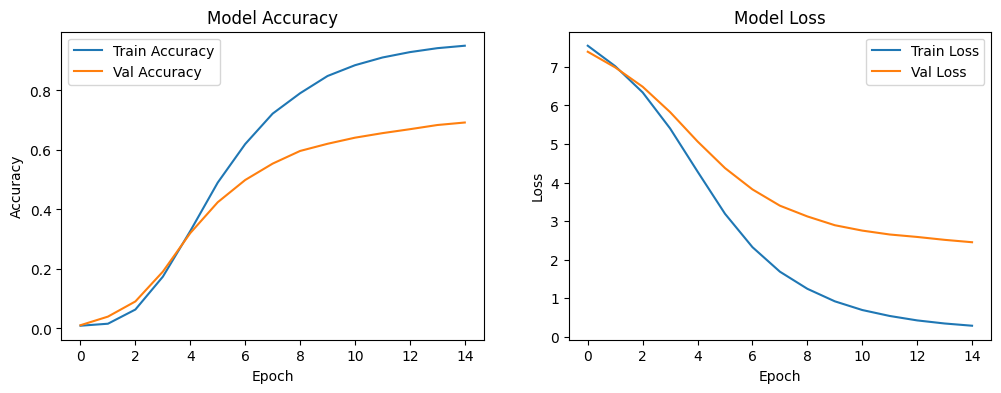

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
def evaluate_top_k(model, X_val, y_val, k=5):
    print(f"Evaluating Top-{k} Accuracy on Validation Set...")
    

    if hasattr(X_val, 'tolist'):
        X_val_input = tf.constant(X_val.tolist())
    else:
        X_val_input = tf.constant(X_val)
        
    probs = model.predict(X_val_input, verbose=0)
    
    top_1_correct = 0
    top_k_correct = 0
    total = len(y_val)
    
    for i in range(total):
        target = y_val[i]
        
        top_indices = probs[i].argsort()[-k:][::-1]
        
        if target == top_indices[0]:
            top_1_correct += 1
            
        if target in top_indices:
            top_k_correct += 1
            
    print(f"Total Samples: {total}")
    print(f"Top-1 Accuracy: {top_1_correct/total:.2%}")
    print(f"Top-{k} Accuracy: {top_k_correct/total:.2%}")

evaluate_top_k(classifier.model, X_val, y_val, k=5)

Evaluating Top-5 Accuracy on Validation Set...
Total Samples: 2489
Top-1 Accuracy: 69.22%
Top-5 Accuracy: 79.39%


In [25]:
def predict_song(snippet, model, encoder, k=3):
    print(f"\nInput Snippet: '{snippet}'")
    
    clean_snip = TextPreprocessor.clean(snippet)
    
    if not clean_snip.strip():
        print("   [!] Input contained only stop words or symbols. Please try again.")
        return

    input_tensor = tf.constant([clean_snip]) 
    
    probs = model.predict(input_tensor, verbose=0)[0]
    
    top_indices = probs.argsort()[-k:][::-1]
    
    print("Predictions:")
    for i, idx in enumerate(top_indices):
        score = probs[idx]
        song_name = encoder.inverse_transform([idx])[0]
        print(f"  {i+1}. {song_name} (Confidence: {score:.2%})")

print("="*50)
print("AUTOMATED MODEL TEST")
print("="*50)

test_snippets = [
    "Look at her face, it's a wonderful face",   
    "Take it easy with me, please touch me gently",
    "please enlighten the lost prayers of my soul", 
]

for snippet in test_snippets:
    try:
        predict_song(snippet, classifier.model, label_encoder)
    except Exception as e:
        print(f"Error predicting '{snippet}': {e}")

AUTOMATED MODEL TEST

Input Snippet: 'Look at her face, it's a wonderful face'
Predictions:
  1. The Real World - Alan Parsons Project (Confidence: 61.95%)
  2. Old Habits Die Hard - Air Supply (Confidence: 13.57%)
  3. Have A Nice Day - Bon Jovi (Confidence: 3.25%)

Input Snippet: 'Take it easy with me, please touch me gently'
Predictions:
  1. Sweet Forgiveness - Bonnie Raitt (Confidence: 22.92%)
  2. The Great Wall Of China - Billy Joel (Confidence: 18.70%)
  3. Honey, Honey - ABBA (Confidence: 7.77%)

Input Snippet: 'please enlighten the lost prayers of my soul'
Predictions:
  1. Captain Crash And The Beauty Queen From Mars - Bon Jovi (Confidence: 47.39%)
  2. Bodyguard - Bee Gees (Confidence: 23.13%)
  3. From A Twinkling Star To A Passing Angel - ABBA (Confidence: 13.79%)


In [26]:
print("\n" + "="*50)
print("LIVE DEMO: TEST YOUR OWN LYRICS")
print("Type 'exit' to stop.")
print("="*50)

while True:
    try:
        user_input = input("\n>> Enter Lyrics: ")
        
        if user_input.lower() in ['exit', 'quit']:
            print("Exiting demo. Goodbye!")
            break
            
        if not user_input.strip():
            continue
            
        predict_song(user_input, classifier.model, label_encoder)
        
    except KeyboardInterrupt:
        print("\nStopped.")
        break
    except Exception as e:
        print(f"Error: {e}")


LIVE DEMO: TEST YOUR OWN LYRICS
Type 'exit' to stop.

Input Snippet: 'Past the falls they call Victoria'
Predictions:
  1. Down With Love - Barbra Streisand (Confidence: 31.68%)
  2. Chinese Bombs - Blur (Confidence: 9.02%)
  3. Black Night - Bob Seger (Confidence: 8.13%)
Exiting demo. Goodbye!
